# Multilayer Perceptron in Keras
In this lesson we will build a multi-layer perceptron (shortened as MLP) classifier. It will recognise handwritten digits from the famous MNIST dataset. When you are reading papers, you'll find often that MNIST is used as a simple toy problem to test new ideas on.

## Loading MNIST
Fortunately Keras already has a function that automatically downloads MNIST so it saves us many lines of codes. First we load the data and then visualize the training examples.

In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the training and test data, helps the training algorithm
x_train = x_train / 255.0
x_test = x_test / 255.0

print("Number of training examples:", len(x_train))
print("Number of test examples:", len(x_test))
print("Image resolution:", x_train.shape[1:])

Number of training examples: 60000
Number of test examples: 10000
Image resolution: (28, 28)


As you can see above, the dataset contains 28x28 black and white images. Now we randomly select some of the training examples

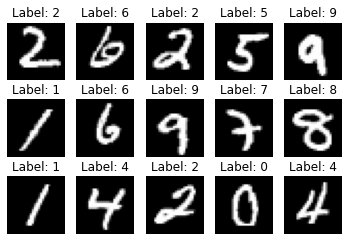

In [ ]:
selected = np.random.choice(len(x_train),15)

plt.figure()
for i, ind in enumerate(selected):
  plt.subplot(3,5,i+1)
  plt.imshow(x_train[ind], cmap='gray')
  plt.title("Label: %d" % y_train[ind])
  plt.axis('off')

# Dense layer

There are many types of layers in a neural network, on the lecture we have seen only one so far, the so called dense layer or fully connected layer. As a reminder it can be written as:

$$y =g(Wx + b),$$ 

where $W$ is the weight matrix (also called kernel in keras), $x$ the input vector, $b$ is the bias vector.

In a dense layer each neuron recieves input from all the neurons in the previous layer. A dense layer can be used to change the dimensionality of the input vector. It is also applicable if there is no structure in the data (i.e. it is not a picture, sound), as it can choose from all the possible connections between two layers. One drawback of  fully connected layers is that they have lots of parameters. A dense layer of 1000 neurons following another dense layer of 1000 neurons have $1000\cdot1000+1000=1001000$ parameters!

## Dense layer in Keras

Class Dense is in the ***tensorflow.keras.layers*** module. Its signature:
```
tensorflow.keras.layers.Dense(units, 
                   activation=None,
                   input_shape=None,
                   use_bias=True, 
                   kernel_initializer='glorot_uniform', 
                   bias_initializer='zeros')
```

**Main arguments**

*  **units:** Positive integer, dimensionality of the output space. This is the number of neurons in the layer.
*  **activation:** Activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x). Corresponds to $g$ in the formula above (see [activations](https://keras.io/activations/)).
*  **kernel_initializer:** Initializer for the kernel weights matrix $W$. It defines how the initial random weights of the layer are calculated (see [initializers](https://keras.io/initializers/)).
*  **bias_initializer:** Initializer for the bias vector $b$. It defines how the initial random weights of the layer are calculated (see [initializers](https://keras.io/initializers/)).
* **input_shape:** The shape of the input data vector. You must specify it only for the first layer, after that it is automatically calculated.



This little peice of code shows how to create a Keras model with two layers: one with 32 neurons and another with 10 neurons

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Create a sequential model. In a sequential model layers simply follow each other.
# There are networks whose architecture is more complex and cannot be
# described as layers on top of each other.
model = Sequential()

# The input of the layer will be arrays of shape (16,)
# and output are arrays of shape (32,)
model.add(Dense(32, input_shape=(16,)))

# after the first layer, you don't need to specify
# the size of the input anymore:
model.add(Dense(10))

# Print summary of the network
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 874
Trainable params: 874
Non-trainable params: 0
_________________________________________________________________


The summary shows each layer, with the number of parameters and output size. The first layer has $32*16+32=544$ parameters ($32*26$ for the weight matrix $W$ and $32$ for the bias $b$). 

The output size is `(None, 32)`, the `None` stands for the batch size. It is not known yet, so it is replaced by a placeholder `None` value.

## Example Keras model on MNIST dataset
In this section we will train a simple classifier that recognizes digits in the dataset.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

In [ ]:
# Define the model
model = Sequential()

model.add(Flatten(input_shape=(28,28)))  # MNIST has 28x28 images. We reshape the input image to a 784=28*28 long vector.
                                         # Dense layers need one dimensional vectors inputs, so we have to reshape the input 2D image.
                                         # The Flatten layer does exactly this: simply reorders the elements, without changing anything
model.add(Dense(512, activation='relu')) # A simple dense layer with ReLU activation
model.add(Dropout(0.2))  # The dropout layer helps generalisation. It randomly drops 0.2 of its inputs.
model.add(Dense(10, activation='softmax')) # Softmax activation function makes sure in the output everything is between 0 and 1
                                           # We have ten classes (10 digits), so we need 10 output values

The activation function of the last layer is the [softmax](https://en.wikipedia.org/wiki/Softmax_function) function. It is the multi-variable equivalent of the sigmoid function. It squashes all the input variables between 0 and 1 such that the sum af the ouputs is 1. This makes it ideal to turn the input into a probability distribution.

You can think of the output of this neural network as a probabilities of the input image being 0, 1, ... 9.

In [ ]:
# Before training a model, you need to configure the learning process with compile() function
model.compile(optimizer='adam', # The optimisation method
              loss='sparse_categorical_crossentropy', # Loss function. Sparse categorical crossentropy can be used if the targets are numbers
              metrics=['accuracy']) # Metrics can be used to monitor the training and testing steps. We here use accuracy, 
                                    # the fraction of the images that are correctly classified

In [ ]:
# Prints a summary representation of your model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


We have set up our network, the only step remaing is to actually train the network. For that, we can use the `fit` function. We have to specify, for how long we want to train the network.

During Stochastic Gradient Descent, we select a batch of the training images and perform a gradient descent update. We do this until we have gone through each image, this is called an epoch. In other words, during one training epoch, the network will see each training image exactly once.

We will train our network for 30 epochs below.

In [ ]:
# fit() function is training the neural network model
# Returns a History object that contains all information collected during training
history = model.fit(x_train, # Train images
                    y_train, # Train labels
                    epochs=30, # Number of epochs to train the model. An epoch is an iteration over the entire x_train and y_train data provided
                    validation_data=(x_test, y_test)) # Tuple on which to evaluate the loss and any model metrics at the end of each epoch. 
                                                      # The model will not be trained on this data

Epoch 1/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2186 - accuracy: 0.9354 - val_loss: 0.0986 - val_accuracy: 0.9698
Epoch 2/30
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0960 - accuracy: 0.9706 - val_loss: 0.0752 - val_accuracy: 0.9772
Epoch 3/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0665 - accuracy: 0.9785 - val_loss: 0.0710 - val_accuracy: 0.9786
Epoch 4/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0540 - accuracy: 0.9830 - val_loss: 0.0669 - val_accuracy: 0.9792
Epoch 5/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0436 - accuracy: 0.9855 - val_loss: 0.0663 - val_accuracy: 0.9812
Epoch 6/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0360 - accuracy: 0.9877 - val_loss: 0.0675 - val_accuracy: 0.9797
Epoch 7/30
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0309 - accuracy: 0.9898 - val_loss: 0.0641 - val_accuracy:

Now we plot the training curves. The training curves shows how the loss and accuracy changes over time. It is a useful tool for debugging the network. By looking at the plots, you can see if the network is still training or has actually converged and you can stop training.

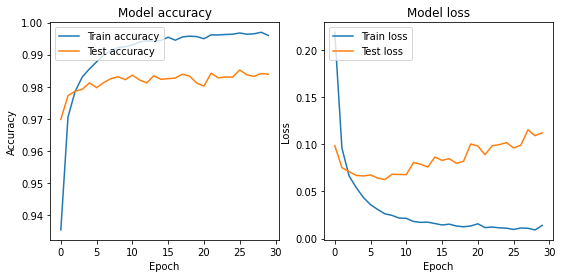

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(9,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model
# Returns the loss value & metrics values for the model in test mode
loss, acc = model.evaluate(x_test, y_test, verbose=0)

print('Test loss: {}'.format(loss))
print('Test accuracy: {:.2%}'.format(acc))

Test loss: 0.11208511888980865
Test accuracy: 98.39%


We got a model that has a 98.3% classification accuracy. Pretty good at first try.

## Example Keras model on Iris dataset
We will try to solve another dataset, the [Iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset. It is much smaller than the previous one. It contains data about the flower sizes of three different species of the Iris flower. 

The task is to predict based on the sepal and petal sizes the actual species.

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [ ]:
# Load the iris dataset
iris_data = load_iris()

print("Number of samples:", len(iris_data.data))
print('Example data: ')
print(iris_data.data[:5])
print('Example labels: ')
print(iris_data.target[:5])

Number of samples: 150
Example data: 
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
Example labels: 
[0 0 0 0 0]


When your target variables (the ones you want to predict) are classes, there are two ways to encode them. In the previous example we could use the straightforward numbering from 0 to 9. In this example we are going to use one-hot encoding.

In the iris dataset target variables have three different values:

In [ ]:
np.unique(iris_data.target)

array([0, 1, 2])

In one-hot encoding instead of representing each class with a number, we represent them as a 0-1 vector, where the element at index *i* is 1 if the sample is in class *i*. For example (remember arrays are zero-indexed):


```
1 -> [0, 1, 0]
2 -> [0, 0, 1]
```

Why is this good? You can think of a one-hot vector as a probability distribution where each element means the probability of the sample being in the class. For example, `[0,1,0]` means there is a 100% chance that the sample is in class 1. If you have multiple labels for a sample, or the annotation is unsure, you can say that it has 70% chance to be in class 1 and 30% chance to be in class 2.

Luckily Keras has the builtin function `to_categorical` to do this for us.

In [ ]:
# Load Iris dataset
x = iris_data.data
y = to_categorical(iris_data.target) # Convert data to one-hot encoding

Lets see how the targets looked like before and after the conversion:

In [ ]:
inds = [0, 120]
print("Original representation:\n", iris_data.target[inds])
print()
print("One-hot encoded representation:\n", y[inds])

Original representation:
 [0 2]

One-hot encoded representation:
 [[1. 0. 0.]
 [0. 0. 1.]]


For this example, we split the training and test set 80%/20%. The `train_test_split` also shuffles the data randomly.

In [ ]:
# Split the data for training and testing
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.20)

In [ ]:
# Define model
model = Sequential()

model.add(Dense(10, activation='relu', input_shape=(4,)))
model.add(Dense(10, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [ ]:
# Before training a model, you need to configure the learning process with compile() function
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', # Use categorical crossentropy for one-hot encoded targets
              metrics=['accuracy']) 

In [ ]:
# fit() function is training the neural network model
# Returns a History object that contains all information collected during training
history = model.fit(train_x, # Train images
                    train_y, # Train labels
                    verbose=2, # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch
                    epochs=100, # Number of epochs to train the model. An epoch is an iteration over the entire train_x and train_y data provided
                    validation_data=(test_x, test_y)) # Tuple on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data

Epoch 1/100
4/4 - 0s - loss: 1.2779 - accuracy: 0.3583 - val_loss: 1.5193 - val_accuracy: 0.2333
Epoch 2/100
4/4 - 0s - loss: 1.2533 - accuracy: 0.3583 - val_loss: 1.4770 - val_accuracy: 0.2333
Epoch 3/100
4/4 - 0s - loss: 1.2338 - accuracy: 0.3583 - val_loss: 1.4354 - val_accuracy: 0.2333
Epoch 4/100
4/4 - 0s - loss: 1.2132 - accuracy: 0.3583 - val_loss: 1.3987 - val_accuracy: 0.2333
Epoch 5/100
4/4 - 0s - loss: 1.1954 - accuracy: 0.3583 - val_loss: 1.3642 - val_accuracy: 0.2333
Epoch 6/100
4/4 - 0s - loss: 1.1794 - accuracy: 0.4167 - val_loss: 1.3306 - val_accuracy: 0.3667
Epoch 7/100
4/4 - 0s - loss: 1.1646 - accuracy: 0.5167 - val_loss: 1.2980 - val_accuracy: 0.3333
Epoch 8/100
4/4 - 0s - loss: 1.1502 - accuracy: 0.4583 - val_loss: 1.2674 - val_accuracy: 0.2667
Epoch 9/100
4/4 - 0s - loss: 1.1359 - accuracy: 0.4000 - val_loss: 1.2387 - val_accuracy: 0.2667
Epoch 10/100
4/4 - 0s - loss: 1.1210 - accuracy: 0.3917 - val_loss: 1.2116 - val_accuracy: 0.2667
Epoch 11/100
4/4 - 0s - loss:

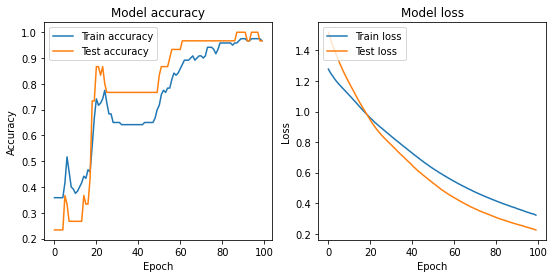

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(9,4))
#plt.subplot(2,1,1)
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model
# Returns the loss value & metrics values for the model in test mode
loss, acc = model.evaluate(test_x, test_y, verbose=0)

print('Validation loss: {}'.format(loss))
print('Validation accuracy: {:.2%}'.format(acc))

Validation loss: 0.22472156584262848
Validation accuracy: 96.67%


On this tiny dataset we achieved perfect accuracy!

# Tasks and experiments
Now that you have seen how classification networks can be created in Keras, here are some problems to experiment with:

* Try translating in the MNIST example the test set by one or two pixels. How well does the model work, does it have the same accuracy? Could you make the network work as well on digits translated by 2 pixels as on untranslated images?
*   Try adding adding more layers to the model. How does it affect the speed of the training and the effectiveness of the model?
*   Train the MNIST model with simple Stochastic Gradient Descent (SGD). Plot the how the accuracy/loss changes over time for both SGD and adam. How does the two compares? Do they reach the same results? Which one trains faster (reaches the same level accuracy earlier)


